# Exploring Ensemble methods

In [1]:
import pandas as pd
import numpy as np

## Load LendingClub dataset

In [2]:
loans = pd.read_csv('lending-club-data.csv')

d:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Modifying the target column

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans',axis=1,inplace=True)

## Selecting features

In [5]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

In [6]:
def onehot_transform(X, names=None,prefix_sep='.'):
    dummies_X = pd.get_dummies(X,prefix_sep=prefix_sep)
    if names is None:
        return dummies_X, dummies_X.columns.values
    else:
        return pd.DataFrame(dummies_X, columns=names).fillna(0)

In [7]:
loans = loans[[target] + features].dropna()

## Make sure the classes are balanced

In [8]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46294


## Split data into training and validation sets

In [9]:
train_idx = pd.read_json('module-8-assignment-1-train-idx.json',typ='series').values
validation_idx = pd.read_json('module-8-assignment-1-validation-idx.json',typ='series').values
train_data, validation_data = loans.iloc[train_idx],loans.iloc[validation_idx]
train_data,names = onehot_transform(train_data,None)
validation_set = onehot_transform(validation_data,names)
features = names.tolist()
features.remove(target)

## Gradient boosted tree classifier

In [10]:

from sklearn.ensemble import GradientBoostingClassifier
model_5 = GradientBoostingClassifier(n_estimators = 5,
                                    max_depth=6,)
model_5.fit(train_data[features],train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Making predictions

In [11]:
# Select all positive and negative examples.
validation_safe_loans = validation_set[validation_data[target] == 1]
validation_risky_loans = validation_set[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


### Predicting on sample validation data

In [12]:
model_5.predict(sample_validation_data[features])

array([ 1,  1, -1,  1], dtype=int64)

In [13]:
model_5.predict_proba(sample_validation_data[features],)[:,1]

array([0.58357669, 0.53050311, 0.46192208, 0.60408361])

## Evaluating the model on the validation data

In [14]:
model_5.score(validation_set[features],validation_set[target])

0.6614605773373546

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3020 1652]
 [1491 3121]]


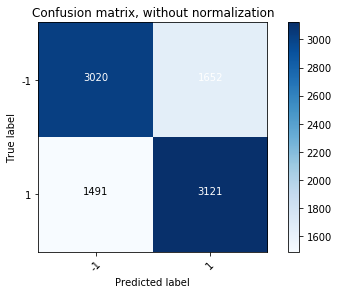

In [17]:
cnf_matrix = confusion_matrix(validation_set[target], model_5.predict(validation_set[features]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=validation_data[target].unique(),
                      title='Confusion matrix, without normalization')

In [18]:
1652

1652

In [19]:
1491

1491

In [20]:
1491*10000+1652*20000

47950000

## Most positive and negative loans

In [21]:
validation_data['predictions']= model_5.predict_proba(validation_set[features])[:,1]

d:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
print("Your loans      : %s\n" % validation_data['predictions'].head(4))
print("Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325])

Your loans      : 24    0.461922
41    0.604084
60    0.479872
93    0.406924
Name: predictions, dtype: float64

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


In [23]:
validation_data.sort_values('predictions',ascending = False)['grade'][0:5]

8021      A
109930    A
10689     A
13391     A
89078     A
Name: grade, dtype: object

In [25]:
validation_data.sort_values('predictions',ascending = True)['grade'][0:5]

84508     C
58794     C
27502     C
114781    D
84921     C
Name: grade, dtype: object

## Effect of adding more trees

In [26]:
model_10 = GradientBoostingClassifier(n_estimators=10,max_depth=6)
model_10.fit(train_data[features],train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [27]:
model_50 = GradientBoostingClassifier(n_estimators=50,max_depth=6)
model_50.fit(train_data[features],train_data[target])
model_100 = GradientBoostingClassifier(n_estimators=100,max_depth=6)
model_100.fit(train_data[features],train_data[target])
model_200 = GradientBoostingClassifier(n_estimators=200,max_depth=6)
model_200.fit(train_data[features],train_data[target])
model_500 = GradientBoostingClassifier(n_estimators=500,max_depth=6)
model_500.fit(train_data[features],train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
print(model_10.score(validation_set[features],validation_set[target]))
print(model_50.score(validation_set[features],validation_set[target]))
print(model_100.score(validation_set[features],validation_set[target]))
print(model_200.score(validation_set[features],validation_set[target]))
print(model_500.score(validation_set[features],validation_set[target]))

0.6665230504093064
0.683649289099526
0.6905428694528221
0.6891426109435588
0.6915122791900044


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [30]:
train_err_10 = 1-model_10.score(train_data[features],train_data[target])
train_err_50 = 1-model_50.score(train_data[features],train_data[target])
train_err_100 = 1-model_100.score(train_data[features],train_data[target])
train_err_200 = 1-model_200.score(train_data[features],train_data[target])
train_err_500 = 1-model_500.score(train_data[features],train_data[target])

In [31]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

In [32]:
validation_err_10 = 1-model_10.score(validation_set[features],validation_set[target])
validation_err_50 = 1-model_50.score(validation_set[features],validation_set[target])
validation_err_100 = 1-model_100.score(validation_set[features],validation_set[target])
validation_err_200 = 1-model_200.score(validation_set[features],validation_set[target])
validation_err_500 = 1-model_500.score(validation_set[features],validation_set[target])

In [33]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

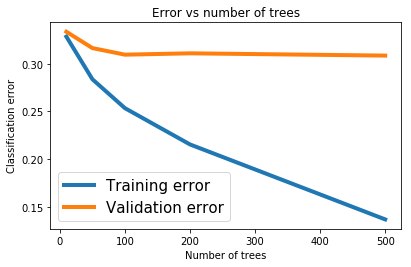

In [34]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')